In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fork-of-credit-card-fraud-detection-models-e29c93/__results__.html
/kaggle/input/fork-of-credit-card-fraud-detection-models-e29c93/credit-card_feat.csv
/kaggle/input/fork-of-credit-card-fraud-detection-models-e29c93/__notebook__.ipynb
/kaggle/input/fork-of-credit-card-fraud-detection-models-e29c93/__output__.json
/kaggle/input/fork-of-credit-card-fraud-detection-models-e29c93/custom.css


In [2]:
#https://docs.dgl.ai/guide/training-edge.html

In [3]:
#install library
%matplotlib inline
!pip install dgl

     |████████████████████████████████| 4.4 MB 4.4 MB/s 


In [4]:
import dgl
from dgl.data import DGLDataset
import torch
import os
import pandas as pd
import torch.nn as nn
import dgl.nn as dglnn
import torch.nn.functional as F
import hashlib
import networkx as nx
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn import metrics
import datetime

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [5]:
#using data ที่ผ่านการ EDA จาก code อันแรก

data = pd.read_csv("../input/fork-of-credit-card-fraud-detection-models-e29c93/credit-card_feat.csv")

In [6]:
data.head()

,amt,city_pop,trans_hour,age,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,...,dist,hist_trans_60d,hist_trans_24h,hist_fraud_trans_24h,hist_trans_avg_amt_60d,hist_fraud_trans_60d,is_fraud,first,last,merchant
0,4.97,3495,0,31.0,0,0,0,0,0,0,...,78.597568,1.0,5.0,0.0,4.970000,0.0,0,Jennifer,Banks,"fraud_Rippin, Kub and Mann"
1,107.23,149,0,41.0,0,0,0,1,0,0,...,30.212176,1.0,2.0,0.0,47.737903,0.0,0,Stephanie,Gill,"fraud_Heller, Gutmann and Zieme"
2,220.11,4154,0,57.0,0,0,0,0,0,0,...,108.206083,8.0,5.0,0.0,377.925000,0.0,0,Edward,Sanchez,fraud_Lind-Buckridge
3,45.00,1939,0,52.0,0,1,0,0,0,0,...,95.673231,1.0,6.0,0.0,45.000000,0.0,0,Jeremy,White,"fraud_Kutch, Hermiston and Farrell"
4,41.96,99,0,33.0,0,0,0,0,0,0,...,77.556744,1.0,4.0,0.0,41.960000,0.0,0,Tyler,Garcia,fraud_Keeling-Crist


In [7]:
#create new column 'full_name'
data['full_name'] = data['first'] + data['last']

In [8]:
#create client dataframe
client = data.drop(columns=['first','last','merchant','city_pop'])

#sum amount of money of all transaction group by client name
client['client_amt'] = client.groupby('full_name')['amt'].transform('sum')
client = client.drop(columns=['amt'])

#remove duplicate client
client.drop_duplicates(subset=['full_name'],keep = 'last', inplace = True)
client.reset_index(inplace=True,drop=True)

#node_id
client["id_client"] = client.index

In [9]:
#create merchant dataframe
merchant = data.drop(columns=['first','last','full_name','city_pop'])

#sum amount of money of all transaction group by merchant
merchant['mer_amt'] = merchant.groupby('merchant')['amt'].transform('sum')
merchant = merchant.drop(columns=['amt'])

#remove duplicate merchant
merchant.drop_duplicates(subset=['merchant'],keep = 'last', inplace = True)
merchant.reset_index(inplace=True,drop=True)

#node_id
merchant["id_merchant"] = merchant.index

In [10]:
#create transaction dataframe

tx = data[['full_name', 'merchant','is_fraud']].copy()
#get id_merchant (node id)
tx = merchant.merge(tx, how = 'left', on = ['merchant', 'merchant'])
#get id_client (node id)
tx = client.merge(tx, how = 'left', on = ['full_name', 'full_name'])

In [11]:
tx_x = tx[['id_client','id_merchant']]
tx_y = tx[['is_fraud']]

In [12]:
from imblearn.over_sampling import SMOTE

#train-test split
X_train, X_test, y_train, y_test = train_test_split(tx_x, tx_y, test_size=0.2, random_state=0)

#upsampling train transaction
sm = SMOTE(random_state=23, sampling_strategy=1)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train_sm['train_mask'] = 1
X_train_sm['test_mask'] = 0
X_test['train_mask'] = 0
X_test['test_mask'] = 1

X = X_train_sm.append(X_test)
y = y_train_sm.append(y_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [13]:
tx =pd.concat([X, y], axis=1)

In [14]:
#seperate data to two dataframe. one is fraud transaction and the other is normal one.
#และจะใช้เป็น edge

fraud = tx[tx.is_fraud != 0]
normal = tx[tx.is_fraud != 1]

fraud.reset_index(inplace=True,drop=True)
normal.reset_index(inplace=True,drop=True)

In [15]:
#feauter of client and merchant. have to be same size

f_c = client.drop(columns=['full_name','id_client','is_fraud'])
f_m = merchant.drop(columns=['merchant','id_merchant','is_fraud'])
f_c = f_c.to_numpy()
f_m = f_m.to_numpy()

In [16]:
#scale
from sklearn.preprocessing import MinMaxScaler

# Define the scaler and apply to the data
scaler = MinMaxScaler()
f_c = scaler.fit_transform(f_c)
f_m = scaler.fit_transform(f_m)

Text(0, 0.5, 'Cumulative explained variance')

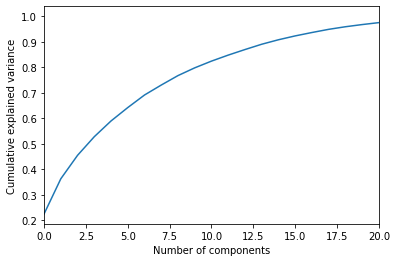

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(f_c)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,20,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [18]:
#จากกราฟด้านบน ถ้าใช้ variable ประมาณ 18 ตัว จะอธบาย varaince ได้ 90%
#จึงทำ pca กับ feature ของ client และ merchant ให้ dimension เหลือ 18

import pickle as pk
pca = PCA(n_components=18)
f_c= pca.fit_transform(f_c)
pk.dump(pca, open("pca.pkl","wb"))
pca_reload = pk.load(open("pca.pkl",'rb'))
f_m = pca_reload.transform(f_m)

# gen graph

In [19]:
#create hetero graph which has two type of node (client and merchant) and has two type of edge (fraud and normal)
#เนื่องจาก dgl ไม่สามารถทำ undirected graph ได้ จึงสร้างเป็น directional ไปกลับ
#insert node feature and edge data into graph

g = dgl.heterograph({('client', '1_is_fraud_buy', 'merchant'):(fraud['id_client'],fraud['id_merchant']),
                     ('client', '0_not_fraud_buy', 'merchant'):(normal['id_client'],normal['id_merchant']),
                     ('merchant', '3_is_fraud_sell', 'client'):(fraud['id_merchant'],fraud['id_client']),
                     ('merchant', '2_not_fraud_sell', 'client'):(normal['id_merchant'],normal['id_client'])})
g.nodes['client'].data['feature'] = torch.from_numpy(f_c).float()
g.nodes['merchant'].data['feature'] = torch.from_numpy(f_m).float()
g.nodes['client'].data['h'] = torch.from_numpy(f_c).float()
g.nodes['merchant'].data['h'] = torch.from_numpy(f_m).float()

g.edges['1_is_fraud_buy'].data['train_mask'] = torch.Tensor(fraud['train_mask']).bool()
g.edges['0_not_fraud_buy'].data['train_mask'] = torch.Tensor(normal['train_mask']).bool()
g.edges['1_is_fraud_buy'].data['test_mask'] = torch.Tensor(fraud['test_mask']).bool()
g.edges['0_not_fraud_buy'].data['test_mask'] = torch.Tensor(normal['test_mask']).bool()
g.edges['3_is_fraud_sell'].data['test_mask'] = torch.Tensor(fraud['test_mask']).bool()
g.edges['2_not_fraud_sell'].data['test_mask'] = torch.Tensor(normal['test_mask']).bool()
g.edges['3_is_fraud_sell'].data['train_mask'] = torch.Tensor(fraud['train_mask']).bool()
g.edges['2_not_fraud_sell'].data['train_mask'] = torch.Tensor(normal['train_mask']).bool()

In [20]:
g

Graph(num_nodes={'client': 973, 'merchant': 693},
      num_edges={('client', '0_not_fraud_buy', 'merchant'): 1288828, ('client', '1_is_fraud_buy', 'merchant'): 1032587, ('merchant', '2_not_fraud_sell', 'client'): 1288828, ('merchant', '3_is_fraud_sell', 'client'): 1032587},
      metagraph=[('client', 'merchant', '0_not_fraud_buy'), ('client', 'merchant', '1_is_fraud_buy'), ('merchant', 'client', '2_not_fraud_sell'), ('merchant', 'client', '3_is_fraud_sell')])

In [21]:
#calculation edge score
# it takes in another graph with only one edge type 
# that “merges” all the edge types to be predicted, and emits the score of each type for every edge.

class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_dims, n_classes):
        super().__init__()
        self.W = nn.Linear(in_dims * 2, n_classes)
        self.clas = n_classes
    def apply_edges(self, edges):
        #concatanate feature of source and destination
        
        x = torch.cat([edges.src['h'], edges.dst['h']], 1)
#         print('cat')
#         print(len(x))
#         print(x)
        #classify using linear classification
        y = self.W(x)
#         print('linear')
#         print(y)
        return {'score': y}

    def forward(self, graph, h):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
#         print('mlp input')
#         print(graph)
#         print(h)
#         print(self.clas)
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [22]:
# Define a Heterograph Conv model
# first performs a separate graph convolution on each edge type, 
# then sums the message aggregations on each edge type as the final result for all node types.
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')
        self.rel = rel_names
    def forward(self, graph, inputs):
#         print(self.rel)
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [23]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroMLPPredictor(out_features, len(rel_names))
    def forward(self, g, x, dec_graph):
        h = self.sage(g, x)
#         print('2')
#         print(self.pred(dec_graph, h))
        return self.pred(dec_graph, h)

In [24]:
#วัดค่าความแม่นยำของโมเดล

def test(g, node_features, dec_graph):
        model.eval()
        out = model(g, node_features, dec_graph)
        # classify ว่าอยู่ class ไหนโดยใช้ argmax function ซึ่งเป็น function ที่จะคืนค่าตำแหน่งที่ element ที่มีค่าสูงสุดอยู่
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        pred[pred==2] = 0
        pred[pred==3] = 1
        
        train_acc = (pred[train_mask] == edge_label[train_mask]).float().mean()
        test_acc = (pred[test_mask] == edge_label[test_mask]).float().mean()

        print('round: ',epoch," loss: ",loss.item())
        print('Test Accuracy: %.2f%%' % (test_acc.item() * 100))
        print("Precision: %.2f%%" % (metrics.precision_score(edge_label[test_mask],pred[test_mask]) * 100))
        print("Recall: %.2f%%" % (metrics.recall_score(edge_label[test_mask], pred[test_mask]) * 100))
        print("F1-Score: %.2f%%" % (metrics.f1_score(edge_label[test_mask], pred[test_mask]) * 100))
        print('----------------')

In [25]:
dec_graph = g['client', :, 'merchant']
edge_label = dec_graph.edata[dgl.ETYPE]

In [26]:
model = Model(18,14,10, g.etypes)
cli_feats = g.nodes['client'].data['feature']
mer_feats = g.nodes['merchant'].data['feature']
node_features = {'client': cli_feats, 'merchant': mer_feats}
# edge_label = g.edges['is_fraud'].data['label'].long()
# edge_label = edge_label.unsqueeze(1).float()
# train_mask = g.edges['is_fraud'].data['train_mask']
# test_mask = g.edges['is_fraud'].data['test_mask']
train_mask = dec_graph.edata['train_mask']
# val_mask = dec_graph.edata['val_mask']
test_mask = dec_graph.edata['test_mask']


opt = torch.optim.Adam(model.parameters())
for epoch in range(100):

    logits= model(g, node_features,dec_graph)
    loss = F.cross_entropy(logits[train_mask], edge_label[train_mask])

    logits = logits.argmax(dim=1)
   
    train_acc = (logits[train_mask] == edge_label[train_mask]).float().mean()
    test_acc = (logits[test_mask] == edge_label[test_mask]).float().mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    if epoch % 10 == 0 or epoch == 99 :
        test(g, node_features, dec_graph)

round:  0  loss:  1.3454025983810425
Test Accuracy: 0.60%
Precision: 0.60%
Recall: 100.00%
F1-Score: 1.19%
----------------
round:  10  loss:  1.1786551475524902
Test Accuracy: 0.60%
Precision: 0.60%
Recall: 100.00%
F1-Score: 1.19%
----------------
round:  20  loss:  0.9834760427474976
Test Accuracy: 0.60%
Precision: 0.60%
Recall: 100.00%
F1-Score: 1.19%
----------------
round:  30  loss:  0.8093209862709045
Test Accuracy: 0.79%
Precision: 0.60%
Recall: 100.00%
F1-Score: 1.19%
----------------
round:  40  loss:  0.6639426946640015
Test Accuracy: 99.86%
Precision: 80.61%
Recall: 100.00%
F1-Score: 89.27%
----------------
round:  50  loss:  0.5553897619247437
Test Accuracy: 100.00%
Precision: 100.00%
Recall: 99.87%
F1-Score: 99.94%
----------------
round:  60  loss:  0.45510798692703247
Test Accuracy: 99.98%
Precision: 100.00%
Recall: 96.20%
F1-Score: 98.06%
----------------
round:  70  loss:  0.35125455260276794
Test Accuracy: 99.95%
Precision: 100.00%
Recall: 91.68%
F1-Score: 95.66%
---